In [89]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import norm, gumbel_r
import math
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd

In [202]:
# Define the hyperparameters

# Covariates parameters  
K = 5
Sigma_rho = 0.95

# Create a diagonal covariance matrix
covariance_matrix = np.eye(K) * Sigma_rho

Covariate Notation:

Let’s assume there are 𝐾 covariates. X is now an 𝑀×𝐾 matrix, where:
- X: The design matrix has 𝑀 items and 
- K covariates.
- 𝛽: A 𝐾×1 vector of coefficients that relates the covariates to the outcome.
The covariate contribution 𝛼 is computed as: 𝛼= Xβ
- α is an 𝑀 × 1 vector, representing the effect of covariates on each item.
- The expression 𝛼⋅1𝐾𝑇 is intended to replicate the effect of 𝛼 across all 𝐾 dimensions.


Transformation with CDF (Φ) and Inverse CDF G to the interval [0, 1]. 𝐺 inverse function is the inverse CDF (quantile function) of another distribution (likely Gumbel). 


The theorem states that ℎ(𝜂:,𝑘) after applying ℎ, follows a probability law 𝑃𝐿(𝛼;𝑀) for each k

In [203]:
# Define parameters and input data
# Load sample data from RData file
robjects.r['load']('/home/doli/Desktop/research/coding/BayesianPartialOrders/data/raw/sample_data.RData')

# Get the loaded data as a DataFrame
# List the variables in the R environment to identify the correct dataset name
r_vars = list(robjects.r.objects())
print(robjects.r.objects())

r_vars = list(robjects.r.objects())
print(f"Available variables in RData file: {r_vars}")
dataset = robjects.r['Y']


['Y']
Available variables in RData file: ['Y']


In [204]:
print(dataset)

[[1]]
[1]  4 14

[[2]]
[1] 14  3  2

[[3]]
[1] 19 12 17

[[4]]
 [1] 19 20 21 12 17 22 23 24 25 26 27 28 29 30 31 32 33 34 10 35  5 36  3 37 14
[26] 16 38  2 39

[[5]]
[1] 23 30 10  1

[[6]]
[1] 30 31 33 10 18  5  1 16

[[7]]
[1] 20 22 23 34 10  3 13  4 38

[[8]]
[1] 10 13 16 39

[[9]]
[1] 25 41  7 38 37 16

[[10]]
[1] 12 26  3

[[11]]
[1] 10  4  3 42

[[12]]
 [1] 44 15 43 35 12 17 22 23 36 14  3 39

[[13]]
 [1] 19 21 12 17 22 23 29 28 27 30 33 25 26 34 10 35 18  6 45 36  3 37  8  4 13
[26] 40 16 38 39  7 46 47

[[14]]
[1] 34 35  5 40 18

[[15]]
[1] 34  5 41 35 40

[[16]]
[1] 34 35  5 41 40

[[17]]
 [1] 19 20 12 17 22 29 23 24 28 27 25 48 10 15 18  6  7 36 41 42 13 16  8  3 14
[26] 40

[[18]]
[1] 22 29 23 10  6 42

[[19]]
 [1] 23 10 35  5 42  4 44 43 15 19 20 22 12 26 29 28 25 48

[[20]]
[1] 49 10  1  9

[[21]]
[1] 15  5  4

[[22]]
[1] 15 43 21 49 12  5 41  9 11

[[23]]
[1] 20 22 30 31 34 10

[[24]]
 [1] 20 12 30 27 10 18  6  3  4 42

[[25]]
[1] 19 20 22

[[26]]
[1] 12 23 10 18  3 14

[

In [211]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
from rpy2.robjects import ListVector

# Extract R data object
with localconverter(pandas2ri.converter):
    r_data = dataset

# Handle OrdDict or similar data structures
if isinstance(r_data, ListVector):
    # Convert ListVector to a list of lists
    data_list = [list(value) for value in r_data]
    
    # Create a DataFrame from the list of lists
    df = pd.DataFrame(data_list)

    # Print the DataFrame to verify its structure
    print(df)

# Determine `m` based on the unique values in the dataset
unique_values = np.unique(df.values)
m = len(unique_values)

print(f"Number of unique nodes (m): {m}")

    0   1     2     3     4     5     6     7     8     9   ...    25    26  \
0    4  14   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
1   14   3   2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
2   19  12  17.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
3   19  20  21.0  12.0  17.0  22.0  23.0  24.0  25.0  26.0  ...  16.0  38.0   
4   23  30  10.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
..  ..  ..   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   
77  22  49   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
78  49  11  18.0   3.0   1.0   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
79  21  23  31.0  49.0  30.0   3.0  13.0   NaN   NaN   NaN  ...   NaN   NaN   
80  23  33   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
81  18  44  41.0   1.0  13.0   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   

     27    28  29  30  31  32  33  34  
0   NaN   N

In [228]:
import numpy as np
import pandas as pd

def create_po_matrix_from_row(row, m):
    """
    Create a partial order matrix (binary adjacency matrix) for a given row.
    Parameters:
    ----------
    row : pd.Series
        A row representing the hierarchical relationships.
    m : int
        The number of nodes in the graph.
    Returns:
    ----------
    np.ndarray
        A binary matrix representing the directed acyclic graph (DAG).
    """
    po_matrix = np.zeros((m, m), dtype=int)
    valid_values = row.dropna().astype(int).tolist()

    for i in range(len(valid_values) - 1):
        po_matrix[valid_values[i] - 1, valid_values[i + 1] - 1] = 1

    return po_matrix

# Number of nodes
m = 50  # Assuming there are 50 nodes in the graph

# Create a 3D matrix to store the partial order matrices for each row
num_rows = len(df)
po_matrices_3d = np.zeros((num_rows, m, m), dtype=int)

# Populate the 3D matrix
for idx, row in df.iterrows():
    po_matrices_3d[idx] = create_po_matrix_from_row(row, m)

# Example: Print the partial order matrix for the first row
print(po_matrices_3d[81])


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [229]:
po_matrix= po_matrices_3d[81]

### Adjacency Matrix Representation:

po0 is a binary matrix with dimensions 5x5. It represents a directed acyclic graph (DAG).
Each element in the matrix (po0[i, j]) is either 0 or 1:
po0[i, j] = 1 indicates that there is a directed edge from node i to node j. In other words, node i is ranked higher than node j.
po0[i, j] = 0 means there is no direct edge from node i to node j.
The adjacency matrix representation of the graph is:

[[0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0]]

This matrix indicates that:
- Node 0 has nodirect edge to any other node.

In [182]:
po_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [223]:
def show_dag(matrix, labels):
    """
    Plots a partial order from an adjacency matrix.
    Parameters:
    ---------
    matrix : np.ndarray
        An adjacency matrix.
    labels : list
        Node labels for the graph.
    """
    G = nx.DiGraph()
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i, j] == 1:
                G.add_edge(labels[i], labels[j])
    
    # Ensure all nodes are added, even if they have no connections
    for label in labels:
        if label not in G:
            G.add_node(label)
    
    pos = nx.kamada_kawai_layout(G)  # Improved layout for better visualization with more uniform spacing
    nx.draw(G, pos, with_labels=True, labels={n: n for n in G.nodes()}, node_size=1000, node_color='lightblue', font_size=8, font_weight='bold', arrowsize=20, edge_color='gray')
    plt.title("Directed Acyclic Graph (DAG)")
    plt.show()


In [173]:

def nle(tr):
    """
    Count the number of linear extensions of the partial order with transitive reduction `tr`.
    Parameters:
    ---------
    tr : np.ndarray
        Transitive reduction adjacency matrix representing the partial order.
    Returns:
    ---------
    int
        Number of linear extensions.
    """
    # If there is only one element, return 1 (base case)
    if len(tr) == 1:
        return 1
    
    n = tr.shape[0]
    cs = np.sum(tr, axis=0)
    
    # If all columns have zero sums, return factorial of n (all nodes are independent)
    if np.sum(cs) == 0:
        return math.factorial(n)
    
    # Identify "free" nodes: nodes that have no incoming or outgoing edges
    csi = (cs == 0)
    bs = np.sum(tr, axis=1)
    bsi = (bs == 0)
    free = np.where(bsi & csi)[0]
    k = len(free)
    
    # If all nodes are "free," return factorial of n
    if k == n:
        return math.factorial(n)
    
    if k > 0:
        tr = np.delete(np.delete(tr, free, axis=0), free, axis=1)
        cs = np.sum(tr, axis=0)
        csi = (cs == 0)
        bs = np.sum(tr, axis=1)
        bsi = (bs == 0)
        fac = math.factorial(n) // math.factorial(n - k)
    else:
        fac = 1

    if (n - k) == 2:
        return fac

    tops = np.where(csi)[0]
    bots = np.where(bsi)[0]

    if len(tops) == 1 and len(bots) == 1:
        return fac * nle(np.delete(np.delete(tr, [tops[0], bots[0]], axis=0), [tops[0], bots[0]], axis=1))
    
    if len(bots) < len(tops):
        tops = bots

    count = 0
    for i in tops:
        trr = np.delete(np.delete(tr, i, axis=0), i, axis=1)
        count += nle(trr)

    return fac * count


In [ ]:
# Define latent2order function
def latent2order(z):
    """
    Converts the latent representation (z) to a list of rankings.
    Parameters:
    ---------
    z : np.ndarray
        Latent positions of shape (n, k).
    Returns:
    ---------
    list
        List of rankings for each dimension.
    """
    if len(z.shape) == 2:
        n, k = z.shape
        resm = n - np.apply_along_axis(lambda x: x.argsort().argsort(), axis=0, arr=z) + 1
        resl = []
        for i in range(k):
            resm[resm[:, i] - 1, i] = np.arange(1, n + 1)
            resl.append(resm[:, i])
    else:
        n = len(z)
        resm = n - z.argsort().argsort() + 1
        resm[resm - 1] = np.arange(1, n + 1)
        resl = [resm]
    return resl

def u2po(U):
    """
    Converts the U-matrix to a partial order (transitive closure).
    Parameters:
    ---------
    U : np.ndarray
        Latent positions of shape (N, K).
    Returns:
    ---------
    np.ndarray
        Transitive closure representing the partial order.
    """
    Z = gumbel_r.ppf(norm.cdf(U))
    tc = nx.transitive_closure(nx.from_numpy_array(order2partial(latent2order(Z), n=NUM_ACTORS), create_using=nx.DiGraph))
    return nx.to_numpy_array(tc)



def seq2dag1(o, n, p=1):
    """
    Creates an adjacency matrix for a DAG based on a given sequence of nodes.
    Parameters:
    ---------
    o : list
        A sequence of nodes to construct the DAG.
    n : int
        Total number of nodes.
    p : int, optional
        The weight of the edges (default is 1).
    Returns:
    ---------
    np.ndarray
        Adjacency matrix representing the DAG.
    """
    m = np.zeros((n, n))
    combs = np.array(np.meshgrid(o, o)).T.reshape(-1, 2)
    m[combs[:, 0] - 1, combs[:, 1] - 1] = p
    return m


def order2partial(v, n=None):
    """
    Outputs the transitive closure of the intersection of the list of complete orders.
    Parameters:
    ---------
    v : list
        A list of complete orders represented as adjacency matrices.
    n : int, optional
        Total number of nodes. If None, it is inferred from the data.
    Returns:
    ---------
    np.ndarray
        Transitive closure of the intersection of the input orders.
    """
    if n is None:
        n = max(max(order.flatten()) for order in v)
    
    w = [seq2dag1(order, n) for order in v]
    x = [nx.transitive_closure(nx.from_numpy_matrix(matrix, create_using=nx.DiGraph)).to_numpy_matrix() for matrix in w]
    z = np.zeros((n, n))
    
    for y in x:
        z += y
    
    return (z == len(v)).astype(int)



In [175]:
def po_to_rand_latent(po_matrix, K):
    """
    Generates random latent positions based on the transitive closure of a partial order matrix.
    Parameters:
    ---------
    po_matrix : np.ndarray
        Partial order adjacency matrix.
    K : int
        Number of dimensions for latent positions.
    Returns:
    ---------
    np.ndarray
        Latent positions of shape (N, K).
    """
    graph_po0 = nx.from_numpy_array(po_matrix, create_using=nx.DiGraph)
    transitive_closure = nx.transitive_closure(graph_po0)
    dist_matrix = nx.floyd_warshall_numpy(transitive_closure)
    latent_positions = distance_matrix(dist_matrix, dist_matrix)[:, :K]  # Take the first K dimensions
    return latent_positions

In [220]:
# Convert the adjacency matrix to a NetworkX directed graph
graph_po0 = nx.from_numpy_array(po_matrix , create_using=nx.DiGraph)
transitive_closure_graph = nx.transitive_closure(graph_po0)
# Convert the adjacency matrix to a NetworkX directed graph
adjacency_matrix = nx.to_numpy_array(transitive_closure_graph)
# Now use the transitive closure graph in the PO2Randlatent function
U0 = po_to_rand_latent(adjacency_matrix, K=2)

/home/doli/Desktop/research/coding/BayesianPartialOrders/.venv/lib/python3.12/site-packages/scipy/spatial/_kdtree.py:60: RuntimeWarning: invalid value encountered in subtract
  return np.sum(np.abs(y-x)**p, axis=-1)


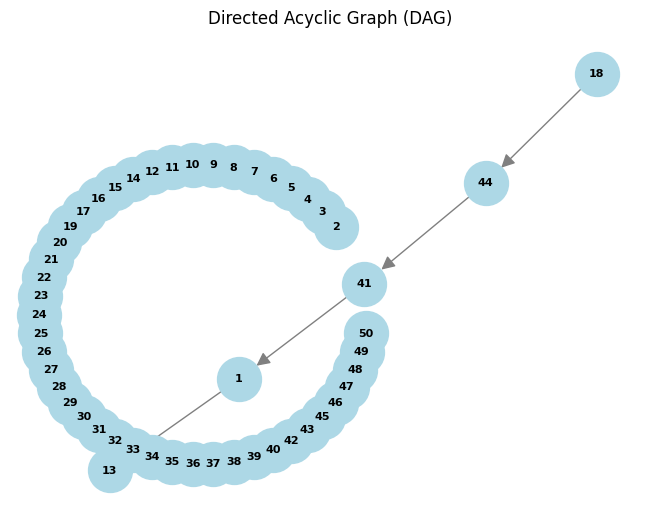

In [224]:
show_dag(po_matrix, row_names)